In [ ]:
#Collecting the data of SBUX Stock using tiingo
import pandas_datareader as pdr
df=pdr.get_data_tiingo('SBUX',api_key=key)
df.to_csv('SBUX.csv')


/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [ ]:
import pandas as pd
df.head()
df=pd.read_csv('SBUX.csv')
df.head()


,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,SBUX,2017-05-18 00:00:00+00:00,59.82,59.94,58.87,59.73,8556793,54.110205,54.218751,53.250882,54.028796,8556793,0.0,1.0
1,SBUX,2017-05-19 00:00:00+00:00,61.36,61.92,59.94,59.94,12369022,55.503213,56.009761,54.218751,54.218751,12369022,0.0,1.0
2,SBUX,2017-05-22 00:00:00+00:00,61.23,61.72,61.03,61.03,6361589,55.385621,55.828851,55.204711,55.204711,6361589,0.0,1.0
3,SBUX,2017-05-23 00:00:00+00:00,61.15,61.50,60.86,61.40,5560428,55.313257,55.629850,55.050938,55.539395,5560428,0.0,1.0
4,SBUX,2017-05-24 00:00:00+00:00,61.89,62.00,60.94,61.40,7196112,55.982625,56.082125,55.123302,55.539395,7196112,0.0,1.0


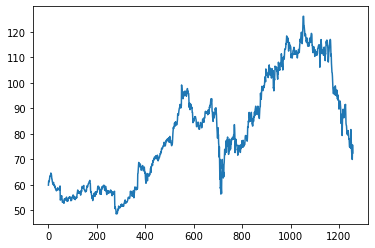

In [ ]:
#Just taking the close column of the dataset and plotting 
df1=df.reset_index()['close']
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
#LSTM is sensitive to the scale of the data ,so lets apply  MinMax Scaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1)) 
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape


(1258, 1)

In [ ]:
#Train Test Split
#For TimeSeries training data is selected continues values rather than random selection
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]





In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train)

[[0.14551084 0.16537668 0.16369969 ... 0.07817337 0.08552632 0.08359133]
 [0.16537668 0.16369969 0.1626677  ... 0.08552632 0.08359133 0.08875129]
 [0.16369969 0.1626677  0.17221362 ... 0.08359133 0.08875129 0.09158927]
 ...
 [0.16602167 0.12242002 0.10332817 ... 0.3498452  0.35152219 0.37319401]
 [0.12242002 0.10332817 0.21078431 ... 0.35152219 0.37319401 0.39125387]
 [0.10332817 0.21078431 0.22278122 ... 0.37319401 0.39125387 0.39667183]]


In [ ]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 9s 325ms/step - loss: 0.0319 - val_loss: 0.0573
Epoch 2/100
12/12 [==============================] - 2s 205ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 3/100
12/12 [==============================] - 2s 205ms/step - loss: 0.0040 - val_loss: 0.0093
Epoch 4/100
12/12 [==============================] - 2s 205ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 5/100
12/12 [==============================] - 2s 203ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 6/100
12/12 [==============================] - 2s 204ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 7/100
12/12 [==============================] - 2s 204ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 8/100
12/12 [==============================] - 2s 204ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 9/100
12/12 [==============================] - 2s 203ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 10/100
12/12 [==============================] - 2s 205ms/step - loss: 0.0017 - val_lo

In [ ]:
## Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

70.4963773485027

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

103.53825880035286

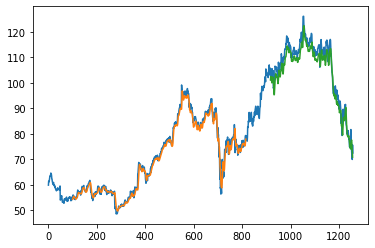

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

441

In [ ]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

[0.8152734778121773,
 0.8234004127966974,
 0.8472652218782248,
 0.8646800825593393,
 0.875128998968008,
 0.8733230134158925,
 0.8827399380804952,
 0.8789989680082557,
 0.8475232198142413,
 0.798503611971104,
 0.8075335397316821,
 0.7614809081527345,
 0.7416150670794632,
 0.7159442724458203,
 0.7137512899896801,
 0.6947884416924663,
 0.6653766769865841,
 0.6345459236326108,
 0.6234520123839009,
 0.6086171310629513,
 0.6162280701754386,
 0.6393188854489162,
 0.6252579979360164,
 0.6068111455108358,
 0.603457172342621,
 0.6278379772961813,
 0.6421568627450978,
 0.6478328173374612,
 0.6345459236326108,
 0.6114551083591329,
 0.599329205366357,
 0.6017801857585137,
 0.5982972136222908,
 0.6268059855521153,
 0.603328173374613,
 0.5829463364293084,
 0.5819143446852424,
 0.5930082559339525,
 0.6016511867905057,
 0.574174406604747,
 0.5779153766769864,
 0.5749484004127965,
 0.53031475748194,
 0.5478586171310629,
 0.568111455108359,
 0.557920536635707,
 0.5366357069143446,
 0.5705624355005159,
 0

In [ ]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.2985874]
101
1 day input [0.82340041 0.84726522 0.86468008 0.875129   0.87332301 0.88273994
 0.87899897 0.84752322 0.79850361 0.80753354 0.76148091 0.74161507
 0.71594427 0.71375129 0.69478844 0.66537668 0.63454592 0.62345201
 0.60861713 0.61622807 0.63931889 0.625258   0.60681115 0.60345717
 0.62783798 0.64215686 0.64783282 0.63454592 0.61145511 0.59932921
 0.60178019 0.59829721 0.62680599 0.60332817 0.58294634 0.58191434
 0.59300826 0.60165119 0.57417441 0.57791538 0.5749484  0.53031476
 0.54785862 0.56811146 0.55792054 0.53663571 0.57056244 0.55456656
 0.53521672 0.46336429 0.45743034 0.50386997 0.49819401 0.44104747
 0.39667183 0.44607843 0.50141899 0.50464396 0.52966976 0.49432405
 0.50761094 0.48606811 0.49767802 0.50193498 0.51393189 0.55069659
 0.54811662 0.54734262 0.55405057 0.51019092 0.45897833 0.44917441
 0.44607843 0.4254386  0.41460268 0.40312178 0.41769866 0.3993808
 0.40067079 0.42156863 0.40802374 0.39241486 0.37899897 0.37977296
 0.3494582  0.3379773  0.36171311 0

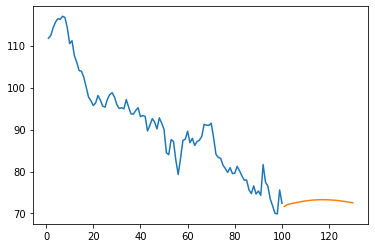

In [ ]:
#Plotting the next 30 days data
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

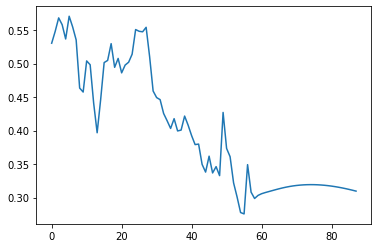

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

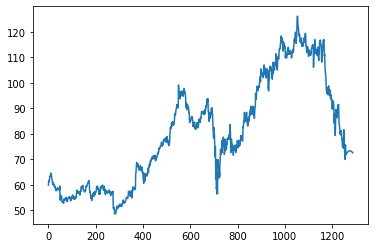

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)